In [1]:
! source ~/Desktop/code/adaptive-ml/venv/bin/activate

In [32]:
import os
import sys
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from copy import deepcopy

import torch
import torch.nn as nn
from torch.optim.optimizer import Optimizer
from torch.utils.tensorboard import SummaryWriter

In [33]:
module_path = os.path.abspath(os.path.join('../../../'))
module_path

'/Users/siddharthchaubal/Desktop/code/adaptive-ml'

In [34]:
if module_path not in sys.path:
    sys.path.append(module_path)

In [38]:
from src.supervised.models import SinusoidMLP
from src.supervised.datasets import Sinusoid

In [39]:
@torch.no_grad()
def generate_task() -> Sinusoid:
    """
    Samples amplitude and phase, then returns a Sine Wave function corresponding to it.

    Returns:
        Returns a neural network that is tuned for few-shot learning.
    """
    amp = torch.rand(1).item() * 4.9 + 0.1
    phase = torch.rand(1).item() * np.pi

    return Sinusoid(amp, phase)


def k_shot_tune(model, task, k_shot, gradient_steps, alpha, device='cpu'):
    optimizer = torch.optim.SGD(model.parameters(), lr=alpha)
    x_batch, target = task.sample(k_shot)
    
    # conversion
    x_batch = torch.FloatTensor(np.array(x_batch).astype(np.float32))
    target = torch.FloatTensor(np.array(target).astype(np.float32))

    loss_fct = nn.MSELoss()

    for epoch in range(gradient_steps):
        loss = loss_fct(model(x_batch.to(device)), target.to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return model

In [40]:
meta_model = SinusoidMLP(input_dim = 1, hidden_dim = 40, output_dim = 1)
meta_model.load_state_dict(torch.load('./models/sinusoid-2022-12-25.pt'))

<All keys matched successfully>

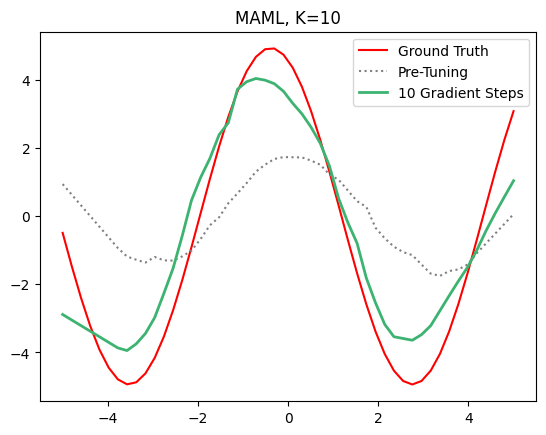

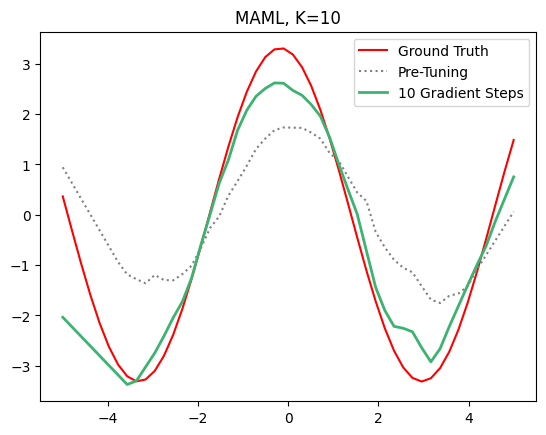

In [ ]:
for i in range(10):
    x = torch.linspace(-5, 5, 50)
    task = generate_task()
    ground_truth_y = task._amplitude * torch.sin(x + task._phase)
    pre_tuning_y = meta_model(x[..., None])

    # Tune
    tuned_model = k_shot_tune(deepcopy(meta_model), task, k_shot = 10, gradient_steps = 10, alpha = 1e-3, device='cpu')
    y = tuned_model(x[..., None])

    # Plot
    plt.title('MAML, K=10')
    plt.plot(x.data.numpy(), ground_truth_y.data.numpy(), c='red', label='Ground Truth')
    plt.plot(x.data.numpy(), pre_tuning_y.data.numpy(), c='gray', linestyle='dotted', label='Pre-Tuning')
    plt.plot(x.data.numpy(), y.data.numpy(), c='mediumseagreen', label='10 Gradient Steps', linewidth='2')
    plt.legend()
    plt.show()